# Computer Vision (911.908)

## <font color='crimson'>Semantic Segmentation (using U-Nets)</font>

---

In this part, we touch upon the problem of *semantic segmentation*, i.e., the problem of assigning a *class label* to each pixel in an image. We address this task with a very popular architecture, called **U-Net**, proposed by Ronneberger et al. in [*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/pdf/1505.04597.pdf). Essentially, we will treat the problem of segmentation as a problem of pixel-wise classification and adjust the loss accordingly.

## Content

- [Architecture](#Architecture)
- [Dataset and data preparation](#Dataset-and-data-preparation)
- [Training](#Training)
- [Evaluation](#Evaluation)     
    - [Visualize training segmentations](#Visualize-training-segmentations)      
    - [Assess testing performance](#Assess-testing-performance)

In [17]:
# run on GPU if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pickle

from skimage import io

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms.functional as VF
from torch.utils.data import random_split

from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

In [3]:
def show(imgs):
    "Helper routine for make_grid"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,5))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def iou(out, tgt, smooth=1e-6):
    """Compute the intersection over union metric as a quality measure"""
    inter = torch.logical_and(out, tgt).float().sum((1,2))
    union = torch.logical_or(out, tgt).float().sum((1,2))
    return (inter + smooth) / (union + smooth) 

## Architecture

Below, we implement the U-Net architecture as shown in Fig.1 of the paper (mentioned above). Essentially, there are two *paths*, a **contracting** and an **expanding** path. 

Along the contracting path (which is essentially a variant of a ConvNet as you would use it for classification), we repeatedly apply convolution, ReLU and max-pooling operations. The convolutions are `3x3` convolutions, the max-pooling operation has a filter size of 2 and a stride of 2. The latter essentially downsamples the input. Below, we use `nn.Conv2d` with a padding of 1 to ensure that the spatial dimensionality of the input does not change.



In [4]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   

In [5]:
# lets test the block
block = double_conv(10,20)
x = torch.rand(16,10,128,128)
block(x).size()

torch.Size([16, 20, 128, 128])

In [6]:
class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## Dataset and data preparation

We will use a slightly modified version of the nuclei dataset from the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/) on Kaggle. Originally each object (nuclei) in an image has its own segmentation mask. Segmenting the nuclei and identifying each instance would be called *instance segmentation*. However, we simply aggregate all masks into **one** mask and our goal is simply to correctly segment all objects, regardless of the object ID.

To boil things down to the basics, I already prepared the training/validation/testing data in the form of lists of numpy arrays.

In [90]:
"""
The following code requires the googledrivedownloader module; install via

    pip install googledrivedownloader
"""

path = Path('./data/train')
path.mkdir(parents=True,exist_ok=True)

img_id = '1y8AQlURCgcq4GSNPtxuAkTHYT2pRdofy'
msk_id = '1x5AgrSECZWov6y1rZpSIeXCptCnPbV9r'

gdd.download_file_from_google_drive(file_id=img_id, dest_path='./data/train/img.pkl', unzip=False)
gdd.download_file_from_google_drive(file_id=msk_id, dest_path='./data/train/msk.pkl', unzip=False)

In [91]:
# Loading the training data
with open('data/train/msk.pkl', 'rb') as fid: msk_org = pickle.load(fid)
with open('data/train/img.pkl', 'rb') as fid: img_org = pickle.load(fid)

In [92]:
print('{}/{} training images/masks'.format(len(img_org),len(msk_org)))

670/670 training images/masks


Lets visualize one image from that dataset.

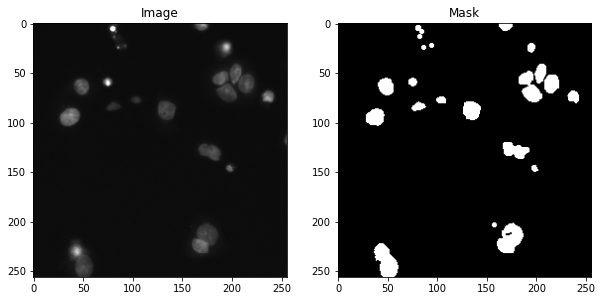

In [95]:
fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(10,5))
axs[0,0].imshow(img_org[15]/255.)
axs[0,0].set_title('Image');
axs[0,1].imshow(msk_org[15]/255., cmap='gray')
axs[0,1].set_title('Mask');

Next, we prepare a `torch.utils.data.Dataset` that we can use with PyTorch's `torch.utils.data.DataLoader`.

In [96]:
class ImageDataset(Dataset):
    def __init__(self, img: list, msk: list, img_tf=None, msk_tf=None):
        self.img = img 
        self.msk = msk
        self.img_tf = img_tf
        self.msk_tf = msk_tf
        
    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        # get (idx)-image and rearrange axsis to (3,W,H)
        img = np.transpose(self.img[idx],(2,0,1))
        msk = self.msk[idx]
        
        # apply transforms if needed
        if self.img_tf:
            img = self.img_tf(self.img[idx])
        if self.msk_tf:
            msk = self.msk_tf(self.msk[idx])
        return img, msk

As the images in the lists are of different spatial size, we will compose a transform that resizes all images to $128\times 128$ pixel by first converting the numpy arrays to a PyTorch tensor, then to a PIL images, followed by resizing and converting back to a PyTorch tensor.

In [97]:
img_tf = transforms.Compose([
   transforms.ToTensor(),
   transforms.ToPILImage(),
   transforms.Resize((128,128)),
   transforms.ToTensor()
])

Lets try this out and check the transformed images ...

In [98]:
ds = ImageDataset(img_org, msk_org, img_tf=img_tf, msk_tf=img_tf)

ds_trn, ds_tst = random_split(ds, [500, 170], generator=torch.Generator().manual_seed(42))

dl_trn = DataLoader(ds_trn, batch_size=32, shuffle=True)
dl_tst = DataLoader(ds_tst, batch_size=32, shuffle=False)

print('{} training, {} testing samples!'.format(len(ds_trn), len(ds_tst)))

500 training, 170 testing samples!


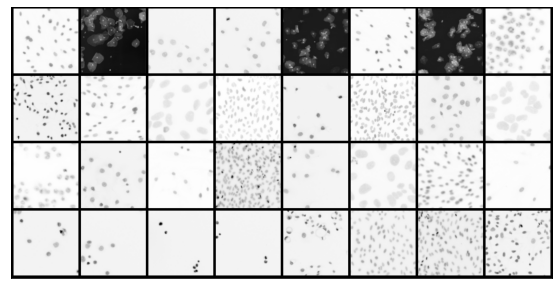

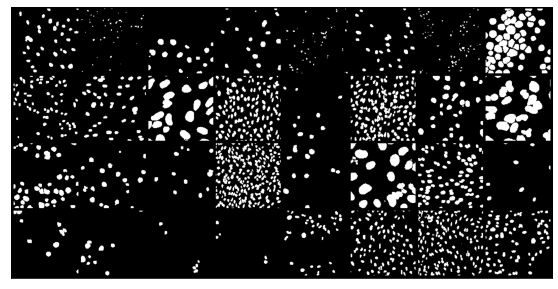

In [99]:
batch = next(iter(dl_trn))

# show original images
grid = make_grid(batch[0],scale_each=True,padding=5)
show(grid)

# show ground truth segmentation masks (binary 0/1)
grid = make_grid(batch[1].float(),scale_each=True,padding=5)
show(grid)

## Training

<div class="alert alert-block alert-info">
In case you do not have a GPU, do not try to train on CPU (unless you are very, very patient). Alternatively, you can download a pre-trained model (see below).
</div>

In [16]:
config = {'n_epochs': 100, 'lr': 0.1}

# instantiate UNet model
model = UNet(1).to(DEVICE)

# define the loss function 
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.))

# instantiate optimizer and learning rate scheduler
optim = SGD(model.parameters(), lr=config['lr'], momentum=0.9)
scheduler = CosineAnnealingLR(optim, T_max=config['n_epochs'])

for e in range(config['n_epochs']):
    e_loss = 0
    IoUs = []
    
    for x,y in dl_trn:

        model.train()
        x = x.to(DEVICE)
        y = y.to(DEVICE)    

        optim.zero_grad()
        out = model(x)
                
        loss = loss_fn(out,y.float())
        loss.backward()
        
        optim.step()
        e_loss += loss.item()
        
        o_cpu = torch.sigmoid(out.detach().cpu().squeeze(1))>0.5
        y_cpu = y.detach().cpu().squeeze(1).bool()
        [IoUs.append(score.item()) for score in iou(o_cpu, y_cpu)]
    
    scheduler.step()
    print('Epoch: {:04d} | BCE-Loss: {:.4f} | IoU: {:.4f}'.format(
        e,
        e_loss/len(dl_trn), 
        np.mean(IoUs)))

Epoch: 0000 | BCE-Loss: 0.6973 | IoU: 0.4401
Epoch: 0001 | BCE-Loss: 0.3598 | IoU: 0.6071
Epoch: 0002 | BCE-Loss: 0.3710 | IoU: 0.6026
Epoch: 0003 | BCE-Loss: 0.3135 | IoU: 0.6187
Epoch: 0004 | BCE-Loss: 0.3047 | IoU: 0.6267
Epoch: 0005 | BCE-Loss: 0.3140 | IoU: 0.6383
Epoch: 0006 | BCE-Loss: 0.2734 | IoU: 0.6612
Epoch: 0007 | BCE-Loss: 0.2458 | IoU: 0.6848
Epoch: 0008 | BCE-Loss: 0.2372 | IoU: 0.6728
Epoch: 0009 | BCE-Loss: 0.2168 | IoU: 0.7020
Epoch: 0010 | BCE-Loss: 0.2377 | IoU: 0.6965
Epoch: 0011 | BCE-Loss: 0.2265 | IoU: 0.7067
Epoch: 0012 | BCE-Loss: 0.2175 | IoU: 0.7187
Epoch: 0013 | BCE-Loss: 0.2266 | IoU: 0.7102
Epoch: 0014 | BCE-Loss: 0.2100 | IoU: 0.7253
Epoch: 0015 | BCE-Loss: 0.2170 | IoU: 0.7053
Epoch: 0016 | BCE-Loss: 0.2129 | IoU: 0.7196
Epoch: 0017 | BCE-Loss: 0.1951 | IoU: 0.7362
Epoch: 0018 | BCE-Loss: 0.2007 | IoU: 0.7276
Epoch: 0019 | BCE-Loss: 0.2245 | IoU: 0.7143
Epoch: 0020 | BCE-Loss: 0.2062 | IoU: 0.7118
Epoch: 0021 | BCE-Loss: 0.1851 | IoU: 0.7390
Epoch: 002

Lets save the model for later ...

In [100]:
model = model.to('cpu')
torch.save(model.state_dict(), './models/unet.pth')

... and load the model (as a sanity check :)

In [104]:
path = Path('./models')
path.mkdir(parents=True,exist_ok=True)

model_id = '1Zm05xkHHffNrxBN62Fe1QlFawBfrqUph'
gdd.download_file_from_google_drive(file_id=model_id, dest_path='./models/unet.pth', unzip=False)

model = UNet(1)
model.load_state_dict(torch.load('./models/unet.pth'))
model = model.to(DEVICE)
model.eval();

## Evaluation

### Visualize training segmentations

Lets draw a batch of training instances from our dataloader, run them through the model and overlay the predicted segmentation mask on top of the images.



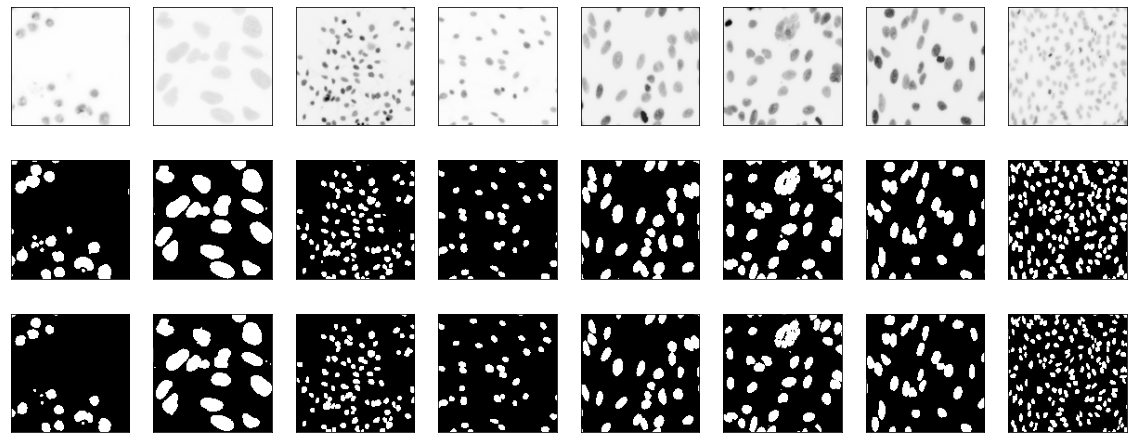

In [105]:
model.eval()

img_batch, msk_batch = next(iter(dl_trn))
img_batch, msk_batch = img_batch.to(DEVICE), msk_batch.to(DEVICE)
out_batch = model(img_batch)

fig, axs = plt.subplots(ncols=8, nrows=3, squeeze=False, figsize=(20,8))
for i in range(8):
    axs[0,i].imshow(img_batch[i,:,:,:].squeeze().permute(1,2,0).detach().cpu().numpy())
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[1,i].imshow(out_batch[i,:,:,:].squeeze().detach().cpu().numpy()>0.5, cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[2,i].imshow(msk_batch[i,:,:,:].squeeze().detach().cpu().numpy(), cmap='gray')
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])    

### Assess testing performance

To assess testing performance, we run all **170** testing images (not seen during training) through the model and compute the IoU score per image. Finally, we average all IoUs.

In [106]:
model.eval()
segs = []
msks = []
with torch.no_grad():
    for img,msk in dl_tst:
        img = img.to(DEVICE)
        msk = msk.to(DEVICE)
        seg = model(img)
        segs.append(seg.detach().cpu())
        msks.append(msk.detach().cpu())

segs = torch.cat(segs)
msks = torch.cat(msks)

test_IoU = [iou(torch.sigmoid(segs[i])>0.5, msks[i].bool()).item() for i in range(segs.size(0))]
print('Testing IoU: {:.4f} +/- {:.4f}'.format(np.mean(test_IoU), np.std(test_IoU))) 

Testing IoU: 0.7806 +/- 0.1366
